In [ ]:
!nvidia-smi

Thu May  5 22:10:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 10.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 78 kB 7.3 MB/s 
     |████████████████████████████████| 69 kB 7.6 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=626634 sha256=e63500dcee3d6238b95d3ee555ce47db0d9d1ea2112c97044b0e0821ac4b7a01
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2022.1.7-py2.py3-none-any.whl size=64772 sha256=46a87af483233b0608cb62a2453214c12ca9e6034eb0674723ac6d7f4029b217
  Stored in directory: /root/.cache/pip/wheels/24/c3/8d/9b093180175460a5fc613220b26027ae97cecbbf94fd3822af
Successfully built pycuda pytools


In [ ]:
import numpy as np
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
from matplotlib import pyplot as plt
from PIL import Image
import time
%matplotlib inline 

In [ ]:
cuda.init()
device = cuda.Device(0) # enter your gpu id here
ctx = device.make_context()

# PyCUDA examples

---



CUDA Example 1

In [ ]:
np.random.seed(1729)
a = np.random.randn(4,4)

In [ ]:
a = a.astype(np.float32)

In [ ]:
a_gpu = cuda.mem_alloc(a.nbytes)

In [ ]:
cuda.memcpy_htod(a_gpu, a)

In [ ]:
mod = SourceModule("""
  __global__ void doublify(float *a)
  {
    int idx = threadIdx.x + threadIdx.y*4;
    a[idx] *= 2;
  }
  """)

In [ ]:
func = mod.get_function("doublify")
func(a_gpu, block=(4,4,1))

In [ ]:
a_doubled = np.empty_like(a)
cuda.memcpy_dtoh(a_doubled, a_gpu)
print(a_doubled)
print(a)

[[-1.3746789  -1.6419895   3.3047218  -1.1505861 ]
 [ 2.1979356   1.8518921  -1.9868276  -1.7164422 ]
 [ 0.14977352  1.058711    0.2419031  -0.44884723]
 [-3.113357    0.11188176  0.32294306 -4.2692833 ]]
[[-0.6873394  -0.82099473  1.6523609  -0.57529306]
 [ 1.0989678   0.92594606 -0.9934138  -0.8582211 ]
 [ 0.07488676  0.5293555   0.12095155 -0.22442362]
 [-1.5566785   0.05594088  0.16147153 -2.1346416 ]]


CUDA example 2

In [ ]:
b = np.random.randn(4,4)
b = b.astype(np.float32)
c = np.random.randn(4,4)
c = c.astype(np.float32)

In [ ]:
mod2 = SourceModule("""
  __global__ void add2(float *a, float *b)
  {
    int idx = threadIdx.x + threadIdx.y*4;
    a[idx] += b[idx];
  }
  """)

In [ ]:
b_gpu = cuda.mem_alloc(b.nbytes)
c_gpu = cuda.mem_alloc(c.nbytes)

cuda.memcpy_htod(b_gpu, b)
cuda.memcpy_htod(c_gpu, c)

In [ ]:
func = mod2.get_function("add2")
func(b_gpu,c_gpu, block=(4,4,1))

In [ ]:
added = np.empty_like(b)
cuda.memcpy_dtoh(added, b_gpu)
print(added)
print(b)
print(c)

[[-0.40068582  0.05749813  1.1325113  -0.99515617]
 [ 1.5589099   0.44708318  2.1112385   0.6726134 ]
 [ 0.620136    1.2447989   0.99837494  0.12565106]
 [-1.3271421   0.7232361   0.5958346  -0.3893862 ]]
[[ 0.38603088  0.23064111 -1.1869708  -0.6665516 ]
 [ 1.7977669   0.66379833  1.1238116  -1.1343062 ]
 [ 1.1844498   0.70126235  0.45549637 -0.0814869 ]
 [-1.0958686   0.4407169   1.6427085   0.4479594 ]]
[[-0.7867167  -0.17314298  2.319482   -0.32860455]
 [-0.23885697 -0.21671516  0.98742694  1.8069196 ]
 [-0.56431377  0.5435365   0.54287857  0.20713796]
 [-0.23127358  0.28251922 -1.0468739  -0.8373456 ]]


# Image Processing

In [ ]:
def init_test_images(image_size=(16, 16)):
    a = np.zeros(image_size)
    b = np.ones(image_size)
    b *= 255
    return a, b

In [ ]:
mod3 = SourceModule("""
  __global__ void alpha_blend(float *a, float *b)
  {
    int idx = threadIdx.x + threadIdx.y * 16;
    float percentage = (float)threadIdx.x / 16.0;
    a[idx] = (1 - percentage) * a[idx] + b[idx] * (percentage);
  }
  """)

In [ ]:
a, b = init_test_images()

a = a.astype(np.float32)
b = b.astype(np.float32)

a_gpu = cuda.mem_alloc(a.nbytes)
b_gpu = cuda.mem_alloc(b.nbytes)

cuda.memcpy_htod(a_gpu, a)
cuda.memcpy_htod(b_gpu, b)

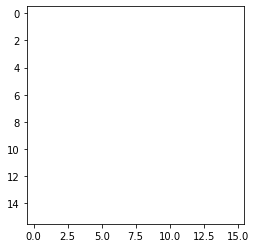

In [ ]:
plt.imshow(b, cmap='gray', vmin=0, vmax=255)
plt.show()

In [ ]:
func = mod3.get_function("alpha_blend")
func(b_gpu,a_gpu, block=(16,16,1))

In [ ]:
added = np.empty_like(b)
cuda.memcpy_dtoh(added, b_gpu)
print(added)
print(b)
print(a)

[[255.     239.0625 223.125  207.1875 191.25   175.3125 159.375  143.4375
  127.5    111.5625  95.625   79.6875  63.75    47.8125  31.875   15.9375]
 [255.     239.0625 223.125  207.1875 191.25   175.3125 159.375  143.4375
  127.5    111.5625  95.625   79.6875  63.75    47.8125  31.875   15.9375]
 [255.     239.0625 223.125  207.1875 191.25   175.3125 159.375  143.4375
  127.5    111.5625  95.625   79.6875  63.75    47.8125  31.875   15.9375]
 [255.     239.0625 223.125  207.1875 191.25   175.3125 159.375  143.4375
  127.5    111.5625  95.625   79.6875  63.75    47.8125  31.875   15.9375]
 [255.     239.0625 223.125  207.1875 191.25   175.3125 159.375  143.4375
  127.5    111.5625  95.625   79.6875  63.75    47.8125  31.875   15.9375]
 [255.     239.0625 223.125  207.1875 191.25   175.3125 159.375  143.4375
  127.5    111.5625  95.625   79.6875  63.75    47.8125  31.875   15.9375]
 [255.     239.0625 223.125  207.1875 191.25   175.3125 159.375  143.4375
  127.5    111.5625  95.625   79

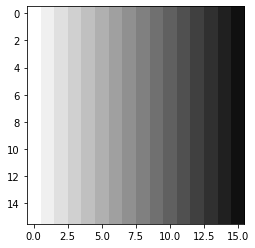

In [ ]:
plt.imshow(added, cmap='gray', vmin=0, vmax=255)
plt.show()

In [ ]:
mod4 = SourceModule("""
  __global__ void alpha_blend_block(float* MatA, float* MatB, float* MatC)
  {
    int N = 256;
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;
    float percentage = (float)j / N;
    if (i < 256 && j < 256) {
        MatC[i * 256 + j] = (1 - percentage) * MatA[i * 256 + j] + MatB[i * 256 + j] * (percentage);
    }
  }
  """)

In [ ]:
c, d = init_test_images((256, 256))

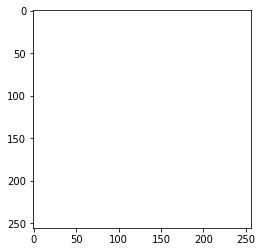

In [ ]:
plt.imshow(d, cmap='gray', vmin=0, vmax=255)
plt.show()

In [ ]:
c = c.astype(np.float32)
d = d.astype(np.float32)
added = c.astype(np.float32)

c_gpu = cuda.mem_alloc(c.nbytes)
d_gpu = cuda.mem_alloc(d.nbytes)
added_gpu = cuda.mem_alloc(added.nbytes)

cuda.memcpy_htod(c_gpu, c)
cuda.memcpy_htod(d_gpu, d)
cuda.memcpy_htod(added_gpu, added)

In [ ]:
def cuda_alpha_blending(c, d):
    c1 = c.astype(np.float32)
    d1 = d.astype(np.float32)
    added = c.astype(np.float32)

    c_gpu = cuda.mem_alloc(c1.nbytes)
    d_gpu = cuda.mem_alloc(d1.nbytes)
    added_gpu = cuda.mem_alloc(added.nbytes)

    cuda.memcpy_htod(c_gpu, c1)
    cuda.memcpy_htod(d_gpu, d1)
    cuda.memcpy_htod(added_gpu, added)

    # func = mod4.get_function("alpha_blend_block")
    # func(c_gpu, d_gpu, added_gpu, block=(16,16,3), grid=((300+16)//16,(300+16)//16))

    final = np.empty_like(added)
    cuda.memcpy_dtoh(final, added_gpu)

In [ ]:
def cpu_alpha_blending(c, d):
    final = np.empty_like(c)
    for i in range(300):
        for j in range(300):
            percentage = j / 300.0
            final[i][j] = c[i][j] * percentage + d[i][j] * (1 - percentage)
    return final

In [ ]:
final = cpu_alpha_blending(apple_img, orange_img)

In [ ]:
func = mod4.get_function("alpha_blend_block")
func(c_gpu, d_gpu, added_gpu, block=(16,16,1), grid=(16,16))

In [ ]:
final = np.empty_like(added)
print(added_gpu)
cuda.memcpy_dtoh(final, added_gpu)
print(final)
print(c)
print(d)

[[  0.           0.99609375   1.9921875  ... 252.01172    253.00781
  254.0039    ]
 [  0.           0.99609375   1.9921875  ... 252.01172    253.00781
  254.0039    ]
 [  0.           0.99609375   1.9921875  ... 252.01172    253.00781
  254.0039    ]
 ...
 [  0.           0.99609375   1.9921875  ... 252.01172    253.00781
  254.0039    ]
 [  0.           0.99609375   1.9921875  ... 252.01172    253.00781
  254.0039    ]
 [  0.           0.99609375   1.9921875  ... 252.01172    253.00781
  254.0039    ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]]


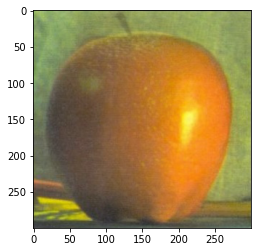

In [ ]:
plt.imshow(final)
plt.show()

In [ ]:
n_iter = 10000
tic = time.clock()

for i in range(n_iter):
    cuda_alpha_blending(c, d)

toc = time.clock()
print(toc - tic)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


5.001943999999998


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


In [ ]:
n_iter = 10000
tic = time.clock()

for i in range(n_iter):
    cuda_alpha_blending(c, d)

toc = time.clock()
print(toc - tic)

In [ ]:
tic = time.clock()

for i in range(n_iter):
    cpu_alpha_blending(c, d)

toc = time.clock()
print(toc - tic)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


In [ ]:
c, d = init_test_images((256, 256, 3))

In [ ]:
apple_img = np.asarray(Image.open('apple.jpeg'))
orange_img = np.asarray(Image.open('orange.jpeg'))

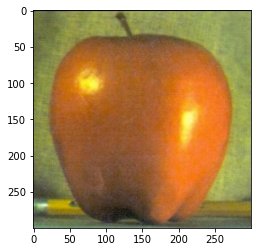

In [ ]:
plt.imshow(apple_img)
plt.show()

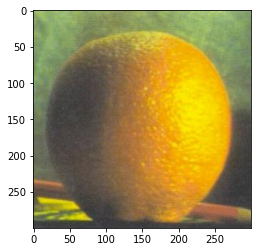

In [ ]:
plt.imshow(orange_img)
plt.show()

In [ ]:
c = apple_img.astype(np.float32)
d = orange_img.astype(np.float32)
added = c.astype(np.float32)

c_gpu = cuda.mem_alloc(c.nbytes)
d_gpu = cuda.mem_alloc(d.nbytes)
added_gpu = cuda.mem_alloc(added.nbytes)

cuda.memcpy_htod(c_gpu, c)
cuda.memcpy_htod(d_gpu, d)
cuda.memcpy_htod(added_gpu, added)

In [ ]:
mod5 = SourceModule("""
  __global__ void alpha_blend_block_rgb(float* MatA, float* MatB, float* MatC)
  {
    int N = 300;
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;
    int c = threadIdx.z;
    float percentage = (float)j / N;
    int idx = i * N + j;
    if (i < 3 * N && j < 3 * N) {
        MatC[idx * 3 + c] = (1 - percentage) * MatA[idx * 3 + c] + MatB[idx * 3 + c] * (percentage);
    }
  }
  """)

In [ ]:
func = mod5.get_function("alpha_blend_block_rgb")
func(c_gpu, d_gpu, added_gpu, block=(16,16,3), grid=((300+16)//16,(300+16)//16))

In [ ]:
final = np.empty_like(added)
print(added_gpu)
cuda.memcpy_dtoh(final, added_gpu)
final = final.astype(np.uint16)
print(final)
print(c)
print(d)

[[[ 19  17  18]
  [ 15  13  14]
  [ 16  15  15]
  ...
  [139 164 123]
  [135 157 118]
  [145 166 127]]

 [[139 174 106]
  [145 181 109]
  [153 186 107]
  ...
  [137 162 120]
  [132 155 113]
  [143 164 125]]

 [[136 172 102]
  [142 178 104]
  [151 184 105]
  ...
  [134 160 115]
  [130 153 109]
  [141 162 121]]

 ...

 [[ 75  76  78]
  [ 58  59  61]
  [ 65  66  70]
  ...
  [ 62  64  63]
  [ 62  64  63]
  [ 61  63  62]]

 [[ 80  81  83]
  [ 60  61  63]
  [ 66  67  69]
  ...
  [ 65  66  68]
  [ 67  68  70]
  [ 64  66  65]]

 [[ 77  77  79]
  [ 64  64  66]
  [ 71  72  74]
  ...
  [ 64  65  67]
  [ 64  65  67]
  [ 59  60  62]]]
[[[ 19.  17.  18.]
  [ 15.  13.  14.]
  [ 16.  14.  15.]
  ...
  [ 31.  33.  28.]
  [ 30.  32.  27.]
  [ 26.  28.  25.]]

 [[ 86.  87.  71.]
  [ 83.  84.  68.]
  [ 84.  85.  69.]
  ...
  [125. 130. 107.]
  [127. 132. 110.]
  [125. 130. 108.]]

 [[106. 110.  73.]
  [106. 110.  73.]
  [106. 111.  71.]
  ...
  [151. 160. 115.]
  [156. 165. 122.]
  [155. 164. 121.]]

 ...

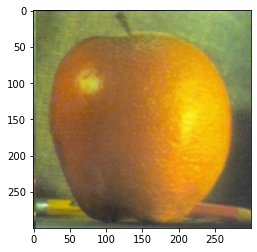

In [ ]:
plt.imshow(final)
plt.show()

In [ ]:
n_iter = 100
tic = time.clock()

for i in range(n_iter):
    cuda_alpha_blending(apple_img, orange_img)

toc = time.clock()
print(toc - tic)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


0.2731339999999989


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


In [ ]:
n_iter = 100
tic = time.clock()

for i in range(n_iter):
    cpu_alpha_blending(apple_img, orange_img)

toc = time.clock()
print(toc - tic)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


37.87462000000001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


In [ ]:
mod5 = SourceModule("""
  __global__ void alpha_blend_block_rgb_horizontal(float* MatA, float* MatB, float* MatC)
  {
    int N = 300;
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;
    int c = threadIdx.z;
    float percentage = (float)j / N;
    int idx = i * N + j;
    if (i < 3 * N && j < 3 * N) {
        MatC[idx * 3 + c] = (1 - percentage) * MatA[idx * 3 + c] + MatB[idx * 3 + c] * (percentage);
    }
  }
  """)

In [ ]:
# a_gpu.free()
# b_gpu.free()
# c_gpu.free()
# d_gpu.free()
# added_gpu.free()